### Pré-processamento de dados

Como vamos fazer um tutorial prático sobre o Transfer Learning, é necessário um breve tratamento dos dados antes de realizar o treinamento da rede neural. Para tudo ficar bem claro, vou colocar bastante código no artigo e também, todo o código está disponível no GitHub.

**Importando bibliotecas**

In [1]:
import warnings 
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam
from keras.utils import to_categorical, np_utils
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Lambda

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,Conv2D,GlobalAveragePooling2D
from keras.models import Sequential, Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD,Adagrad,Adadelta
from keras import losses
from keras.layers import Conv2DTranspose

import random
import tensorflow as tf
import cv2
import os 
import glob

- **Preparando o dataset**

> Neste primeiro momento há necessidade de observar as imagens do dataset e organizá-las em uma estrutura de dados adequada para que seus atributos possam ser extraídos. há então a necessidade de carregar o conjunto de imagens via código.

In [76]:
def load_data(datadir, classes, img_size=224):
    training_data = []
    label = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        #shuffle(shufled_list)
        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img))
            if img_array is None:
                continue
            #img_array = cv2.resize(img_array, (img_size, img_size))
            #img_array = cv2.resize(img_array, (img_size, img_size))
            img_array = cv2.resize(img_array, (128,128), interpolation = cv2.INTER_AREA)
            training_data.append(img_array)
            label.append(classe)
            #label = to_categorical(label, 4)
            

    return training_data, label

#### Definindo as labels
A entrada de nossa rede neural já está pronta, agora devemos definir os rótulos (labels) para o treinamento

In [77]:
data, label = load_data('dataset/tempo/', ['cloudy','rain','shine','sunrise'])

In [78]:
label

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [79]:
label = np.array(label)

3


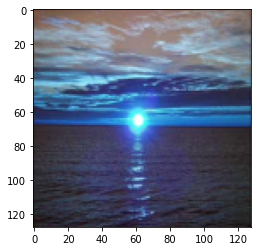

In [80]:
plt.imshow(data[800])
print(label[800])

### Pré-Processamento

In [81]:
##### Filtro de média
blur_data = []
for i in range(len(data)):
    blur_img = cv2.blur(data[i], ksize=(3,3))
    blur_data.append(blur_img)

##### GaussianBlur
gaussian_data = []
for i in range(len(data)):
    gaussian_img = cv2.GaussianBlur(src=data[i], ksize=(15,15),sigmaX=0)
    gaussian_data.append(gaussian_img)

#### Equalização do histograma - HSV
Eq_data = []
for i in range(len(data)):
    img = data[i]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    canais =  cv2.split(hsv)
    cv2.equalizeHist(canais[2],canais[2])
    cv2.merge(canais, hsv)
    Eq_data.append(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))

#### Filtro	Máscara de Desaguçamento - filtro de realce
realce_data = []
for i in range(len(data)):
    imgOriginal = data[i]
    imgSuavizada = cv2.GaussianBlur(imgOriginal, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(imgOriginal, imgSuavizada)
    imgRealcada = cv2.add(imgOriginal, imgDetalhes)
    realce_data.append(imgRealcada)

data_norm = [i/255 for i in data]
HSV_norm = [i/255 for i in Eq_data]
realce_norm = [i/255 for i in realce_data]

In [82]:
data_norm = np.array(data_norm)
type(data_norm)
print(type(label))

<class 'numpy.ndarray'>


### Normalização 

In [33]:
label = keras.utils.to_categorical(label, 4)
len(label)

1123

### Separando treinamento e validação
Agora vamos separar o nosso conjunto e duas partes. Uma para o treinamento e outra para a validação. Idealmente, deveríamos separar isto em três partes, para avaliarmos o desempenho do classificar em um conjunto nunca visto nem para a validação.

In [83]:
#X_train, X_test, y_train, y_test = train_test_split(data_norm, label, test_size=0.3, random_state=15, stratify= label)
X_train, X_test, y_train, y_test = train_test_split(data_norm, label, test_size=0.20, stratify = label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify = y_train)

718
225
180


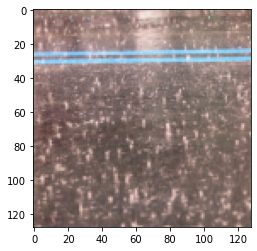

In [84]:
plt.imshow(X_train[0])
print(len(X_train))
print(len(X_test))
print(len(X_val))

y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [85]:
# Para evitar problemas de overfitting, usei o ImageDataGenerator.
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)
datagen.fit(X_train)

#categorical_y_train = keras.utils.to_categorical(y_train)
#categorical_y_test = keras.utils.to_categorical(y_test)

#### InceptionV3

In [93]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
def Inceptionv3():
    inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))
    model = Sequential()
    model.add(inceptionV3)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
def Resnet101V2():

    Resnet101V2 = ResNet101V2(weights='imagenet', include_top=False, input_shape=(128,128,3))

    model = Sequential()
    model.add(Resnet101V2)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


In [92]:
#history = model.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val))
y_val.shape

(180, 4)

In [94]:
#E finalmente, treiná-la:
model = Inceptionv3()
#history = model.fit(X_train, y_train, batch_size = 32, epochs=200)
history = model.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val))

Epoch 1/200
23/23 [==============================] - 80s 3s/step - loss: 1.1284 - accuracy: 0.5752 - val_loss: 1.8318 - val_accuracy: 0.5389
Epoch 2/200
23/23 [==============================] - 84s 4s/step - loss: 0.3233 - accuracy: 0.8900 - val_loss: 0.9393 - val_accuracy: 0.7722
Epoch 3/200
23/23 [==============================] - 91s 4s/step - loss: 0.1221 - accuracy: 0.9652 - val_loss: 0.6184 - val_accuracy: 0.8389
Epoch 4/200
23/23 [==============================] - 94s 4s/step - loss: 0.0605 - accuracy: 0.9875 - val_loss: 0.4150 - val_accuracy: 0.8611
Epoch 5/200
23/23 [==============================] - 109s 5s/step - loss: 0.0688 - accuracy: 0.9777 - val_loss: 0.3045 - val_accuracy: 0.9333
Epoch 6/200
23/23 [==============================] - 95s 4s/step - loss: 0.0328 - accuracy: 0.9889 - val_loss: 0.2752 - val_accuracy: 0.9167
Epoch 7/200
23/23 [==============================] - 90s 4s/step - loss: 0.0635 - accuracy: 0.9833 - val_loss: 0.2612 - val_accuracy: 0.9333
Epoch 8/200


Epoch 59/200
23/23 [==============================] - 84s 4s/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.2896 - val_accuracy: 0.9333
Epoch 60/200
23/23 [==============================] - 87s 4s/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.2961 - val_accuracy: 0.9500
Epoch 61/200
23/23 [==============================] - 84s 4s/step - loss: 0.0086 - accuracy: 0.9958 - val_loss: 0.2723 - val_accuracy: 0.9556
Epoch 62/200
23/23 [==============================] - 88s 4s/step - loss: 0.0050 - accuracy: 0.9972 - val_loss: 0.2329 - val_accuracy: 0.9500
Epoch 63/200
23/23 [==============================] - 91s 4s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2237 - val_accuracy: 0.9389
Epoch 64/200
23/23 [==============================] - 76s 3s/step - loss: 0.0058 - accuracy: 0.9972 - val_loss: 0.2154 - val_accuracy: 0.9444
Epoch 65/200
23/23 [==============================] - 75s 3s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2104 - val_accuracy: 0.9444
Epoch 

KeyboardInterrupt: 

É fácil ver o problema de overfitting nos gráficos acima. A acurácia de treinamento está próxima de 1 enquanto, no teste próxima de 0.7.

Existem várias formas de reduzir o overfitting, como a regularização BatchNormalization, Dropout e também o aumento do conjunto dados. Vamos nos focar nesta ideia de aumentar o conjunto de dados. Sabendo que não temos mais imagens de flores disponíveis, vamos usar o Transfer Learning como uma forma de reduzir o overfitting.

### Transfer Learning
Vamos utilizar o modelo da VGG-16, com pesos treinados na ImageNet, este conjunto de dados é composto por mais de 14 milhões de imagens classificadas em mais de 20000 classes. Sendo assim, é um conjunto substancialmente maior que nosso conjunto de flores.

In [24]:
import keras
from keras.applications import imagenet_utils
vgg = keras.applications.VGG16(input_shape=(224,224,3), include_top = False, weights= 'imagenet')

58889256/58889256 [==============================] - 2s 0us/step


Desta forma, temos um modelo composto apenas pelas camadas convolucionais pré-treinadas da VGG-16. E agora?

Tendo em mente que os recursos da CNN são mais genéricos (ex. detector de borda) nas camadas iniciais e mais específicos (ex. pétalas) do conjunto de dados originais nas camadas posteriores, aqui estão algumas regras comuns para navegar pelos 4 principais cenários:

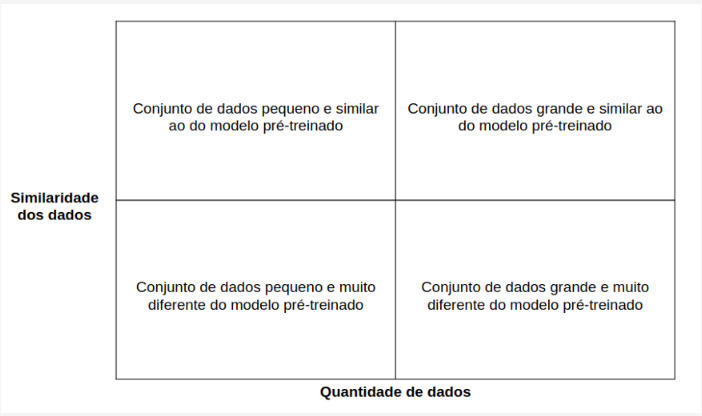

#### Conjunto de dados pequeno e diferente do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Congelamos os pesos das primeiras camadas convolucionais;
- Treina-se a rede neural.

#### Conjunto de dados grande e diferente do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Treina-se a rede neural usando os pesos da ImageNet como valores inciais.

#### Conjunto de dados grande e similar ao do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Pode-se treinar todo o modelo ou congelar os pesos das primeiras camadas convolucionais.

#### Conjunto de dados pequeno e similar ao modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Congelar os pesos das primeiras camadas convolucionais ou todas camadas convolucionais.

Então, em qual dos casos nosso problema de reconhecimento de flores se enquadra? Lembrando que o conjunto de dados possui 4242 amostras de cinco possíveis classes.

Perto do conjunto da ImageNet, nosso conjunto de flores é muito pequeno, então vamos adicionar camadas densamente conectadas e congelar o treinamento de todas as camadas convolucionais.

In [32]:
x = vgg.output
x = Flatten()(x)
x = Dense(3078,activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(5,activation='softmax')(x)
tf_model=Model(inputs=vgg.input,outputs=out)
tf_model.compile(optimizer = Nadam(lr = 0.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])
for layer in tf_model.layers[:20]:
    layer.trainable=False

### Classificando alguns exemplos
Vamos classificar alguns exemplos de flores para ver onde é que nosso modelo está errando mais.

In [29]:
pred = tf_model.predict(X_val)
pred = np.argmax(pred, axis = 1)

27/27 [==============================] - 101s 4s/step


### Conclusão
O Transfer Learning definitivamente será um dos principais impulsionadores para o Machine Learning e para o sucesso do Deep Learning na adoção mainstream na indústria. Através dele é possível acelerar e melhorar um modelo profundo com facilidade, além de também reduzir os custos computacionais atrelados ao treinamento.

Existem diversas outras arquiteturas pré-treinadas como:
- Xception
- VGG-19
- ResNet, ResNetV2, ResNeXt
- InceptionV3
- MobileNet, MobileNetV2
- DenseNet
- NASNet